In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from sklearn import svm, pipeline
from sklearn.kernel_approximation import RBFSampler, Nystroem

In [97]:
""" 
  --kernel trick with support vector classifiers--

- Apply a function (Called Kernel Function) to transform data so that it becomes much easier to model and process.
- Very widly used in ML
- Output of kernel function is called "feature map"
- Mapping of the features from original dimension-space to kernel-space (this mapping is implicit)
- Generated feature maps are implicit feature maps
- common kernel functions are : 1. non-linear  2. quiet complex
- it also does not scale well to very large datasets ('kernel approximations' can be used to solve this issue)
  + kernel approximations can be used to pre-process data before feeding to a Machine Learning model.
  + Nystroem kernels use a low-rank approximation of kernels 
  + RBF or Radial Basis Function kernel relies on a Monte Carlo approximation to kernel values
  
  Summary:
   using kernels with support vector classifiers : 
      1. No kernel trick (faster training, but poor test accuracy)
      2. Implicit kernel trick (best test accuracy, but slowest to train) - it is called implicit, because classifier implicitly applies kernel inside estimator object 
      3. Explicit kernel trick: (explicit, because kernel trick applied during pre-processing)
          3.1 Nystroem
          3.2 Radial Basis Function (RBF) - it scales well even with large training data
""";

In [98]:
letters_df = pd.read_csv('datasets/A_Z Handwritten Data.csv')

In [99]:
letters_df.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [100]:
letters_df.shape

(372450, 785)

In [101]:
# the dataset is very large and we only get 1% of the datatset to work with.
letters_df = letters_df.sample(frac=0.01).reset_index(drop=True)

In [102]:
letters_df.shape

(3724, 785)

In [103]:
LOOKUP = { 0: 'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H', 8:'I',
           9: 'J', 10:'K', 11:'L', 12:'M', 13:'N', 14:'O', 15:'P', 16:'Q',
           17: 'R', 18:'S', 19:'T', 20:'U', 21:'V', 22:'W', 23:'X', 24:'Y', 25:'Z'}

In [104]:
def display_image(features, actual_label):
    
    print("Actual label:" , LOOKUP[actual_label])
    
    plt.imshow(features.reshape(28,28), cmap='Greys')
    
    plt.show()
    

In [105]:
X = letters_df[letters_df.columns[1:]]
y = letters_df[letters_df.columns[0]]

In [106]:
sorted(y.unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25]

In [107]:
y.loc[3]

12

In [108]:
# random pixel values in grayscale image (each pixel can be between 0 and 255)  
X.loc[5].values[100:300]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   9,  89, 204, 210,
        99,  13,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 138, 241,
       255, 255, 193,  79,  11,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  11,
       149, 244, 255, 255, 255, 237, 166,  60,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,  74, 202, 252, 191, 201, 227, 220, 248, 189,  61,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  30, 177, 251, 189,  88, 153, 153,  88, 189, 240, 149,
        13,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,  37, 188, 227,  97,  11,  78,  96,  34, 117,
       255, 204,  71,   0,   0,   0,   0,   0,   0,   0,   0,   

Actual label: O


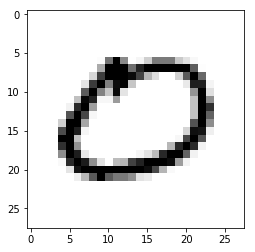

In [109]:
display_image(X.loc[23].values, y.loc[23])

Actual label: F


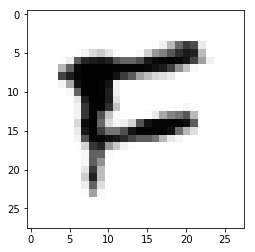

In [110]:
display_image(X.loc[203].values, y.loc[203])

In [112]:
X = X / 255.
X -= X.mean(axis=0)

In [113]:
X.loc[5].values[200:210]

array([-0.00020194, -0.00038048, -0.00057255, -0.00080012, -0.00106354,
       -0.00018198,  0.0015613 ,  0.00216555,  0.00116251,  0.00130837])

In [114]:
n_samples = len(letters_df)
n_samples

3724

In [118]:
# I want to use 50% of data for training and 50% for testing
data_train, labels_train = (X[:n_samples // 2], 
                            y[:n_samples // 2])

In [116]:
data_test, labels_test = (X[n_samples // 2:],
                          y[n_samples // 2:])

In [120]:
data_train.shape, labels_train.shape

((1862, 784), (1862,))

In [122]:
data_test.shape, labels_test.shape

((1862, 784), (1862,))

In [125]:
kernel_svm = svm.SVC(gamma=0.01)

linear_svm = svm.LinearSVC(max_iter=1500)

In [188]:
# pre-processes input data using RBF Explicit kernel Trick and uses the svc classifier
rbf_approx_svm = pipeline.Pipeline([
    ('rbf_sampler', RBFSampler(gamma=0.01, random_state=1)),
    ('svc', svm.LinearSVC())
])

In [187]:
# pre-processes input data using Nystroem and uses the svc classifier
nystroem_approx_svm = pipeline.Pipeline([
    ('nystroem', Nystroem(gamma=0.01, random_state=1)),
    ('svc', svm.LinearSVC())
])

In [143]:
# using kernel svm
start = time()

kernel_svm.fit(data_train, labels_train)
kernel_svm_score = kernel_svm.score(data_test, labels_test)

kernel_svm_time = time() - start

print('Score:', kernel_svm_score)
print('Runtime:' , kernel_svm_time)

Score: 0.1573576799140709
Runtime: 7.734402656555176


In [171]:
# using linear svm - it is faster
start = time()

linear_svm.fit(data_train, labels_train)
linear_svm_score = linear_svm.score(data_test, labels_test)

linear_svm_time = time() - start

print('Score:', linear_svm_score)
print('Runtime:' , linear_svm_time)

Score: 0.1573576799140709
Runtime: 0.5846138000488281


In [172]:
start = time()

# penalty coefficient for misclassified points (deafult is 1)
linear_svm.set_params(C=0.1)
linear_svm.fit(data_train, labels_train)
linear_svm_score = linear_svm.score(data_test, labels_test)

linear_svm_time = time() - start

print('Score:', linear_svm_score)
print('Runtime:' , linear_svm_time)

Score: 0.1573576799140709
Runtime: 0.5861361026763916


In [182]:
start = time()

rbf_approx_svm.set_params(rbf_sampler__n_components=len(data_train))
#rbf_approx_svm.set_params(svm__C=0.1)

rbf_approx_svm.fit(data_train, labels_train)
rbf_approx_svm_score = rbf_approx_svm.score(data_test, labels_test)

rbf_approx_svm_time = time() - start

print('Score:', rbf_approx_svm_score)
print('Runtime:' , rbf_approx_svm_time)

Score: 0.1573576799140709
Runtime: 10.751955032348633


In [190]:
start = time()

nystroem_approx_svm.set_params(nystroem__n_components=len(data_train))
#nystroem_approx_svm.set_params(svm__C=0.1)

nystroem_approx_svm.fit(data_train, labels_train)
nystroem_approx_svm_score = nystroem_approx_svm.score(data_test, labels_test)

nystroem_approx_svm_time = time() - start

print('Score:', nystroem_approx_svm_score)
print('Runtime:' , nystroem_approx_svm_time)

Score: 0.1573576799140709
Runtime: 14.033196926116943
